# BUDT 758X - Data Processing and Analysis in Python
# Final Notebook- Group 29
### Karthik Veeramalai 

# Project Description
In an age where air travel is more common and accessible than ever, there appear to be a myriad of options for the consumer to choose from when he/she wants to book a ticket. But, an element that is often overlooked is the fuel efficiency of the trip. The goal of this project would analyze just that - what is the most fuel-efficient way to get from a source to a destination with the various options that different airlines offer? 

There are multiple ways to get from point A to point B. Let's consider this, a passenger has to travel from Bangalore (IATA:BLR) to Washington D.C (IATA:IAD). The passenger has a multitude of options from various airlines to choose from. **Some** of them are - 
* **Air India** : Fly from Bangalore to New Delhi (IATA:DEL) in a 150 seater narrow body Airbus A320 to New Delhi and then take a direct flight to Washington in a 300 seater Boeing 777, a large twin engine aircraft. 
* **Lufthansa** : Fly to Frankfurt (IATA:FRA) and then to DC, both flights are operated using a 4 engine jumbo with 400 other passengers. 
* **Emirates** : Emirates is a global hub carrier and operates using a hub and spoke model. The flight to Dubai (IATA:DXB) is on a Boeing 777 followed by a journey on the Airbus A380 - the world's largest passenger aircraft, 4 engines, 500 passengers.<br>
* **Etihad Airways** : The first flight to Abu Dhabi (IATA:AUH) is operated using an Airbus A320, the second leg to DC is flown using a Boeing 787-900, a highly efficient modern twin engine aircraft.<br>

**But, which of the above options is likely to consume the least amount of fuel?**

### The project aims to answer/analyze the following questions/problem statements : 

* Among the various options available to complete a trip (as mentioned above), which airline offers the most fuel efficient way to get from a source to destination? The primary objective of the project is to develop a metric for the net fuel effciency for getting from point A to point B across the numerous options available.1
* Analyze the operating patterns of various carriers.


### The data

The project would be using a combination of several datasets that are available or have been scraped off webpages. 
* **[1]** Openflights - Contains route information i.e. source and destination IATA codes of every commercial flight in the world.
* **[2]** MWGG - A json compilation of 28k+ airports/airstrips along with their IATA codes and geographic information (latitude and longitude). 
* **[3]** Planespotters - This data was required to compemnsate for the lack of more particular configuartion of aircrafts in the openflights dataset. This data has been currently scraped using a chrome extension. 
* **[4]** Fuel economy numbers - These have been scraped from the wiki page [here]('https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft'). The data has fuel efficiency numbers for all distance ranges for most modern aircrafts.

### The approach

* Use the route information from [1] and airport data from [2] to calculate distances. Compute the same for an entire fleet, analyze route patterns.
* Since the route data from [1] only consists of a broad family of aircraft that are used to service the route, it is not possible to estimate fuel consumption numbers. To combat this, data from [3] is used to determine the weighted average of fuel consumption for each family of aircraft for a particular fleet. 
* Now determine fuel consumed for a particular journey using data from [4] also find a more efficient way of flying each route.
* Develop an efficiency index for the carriers. 

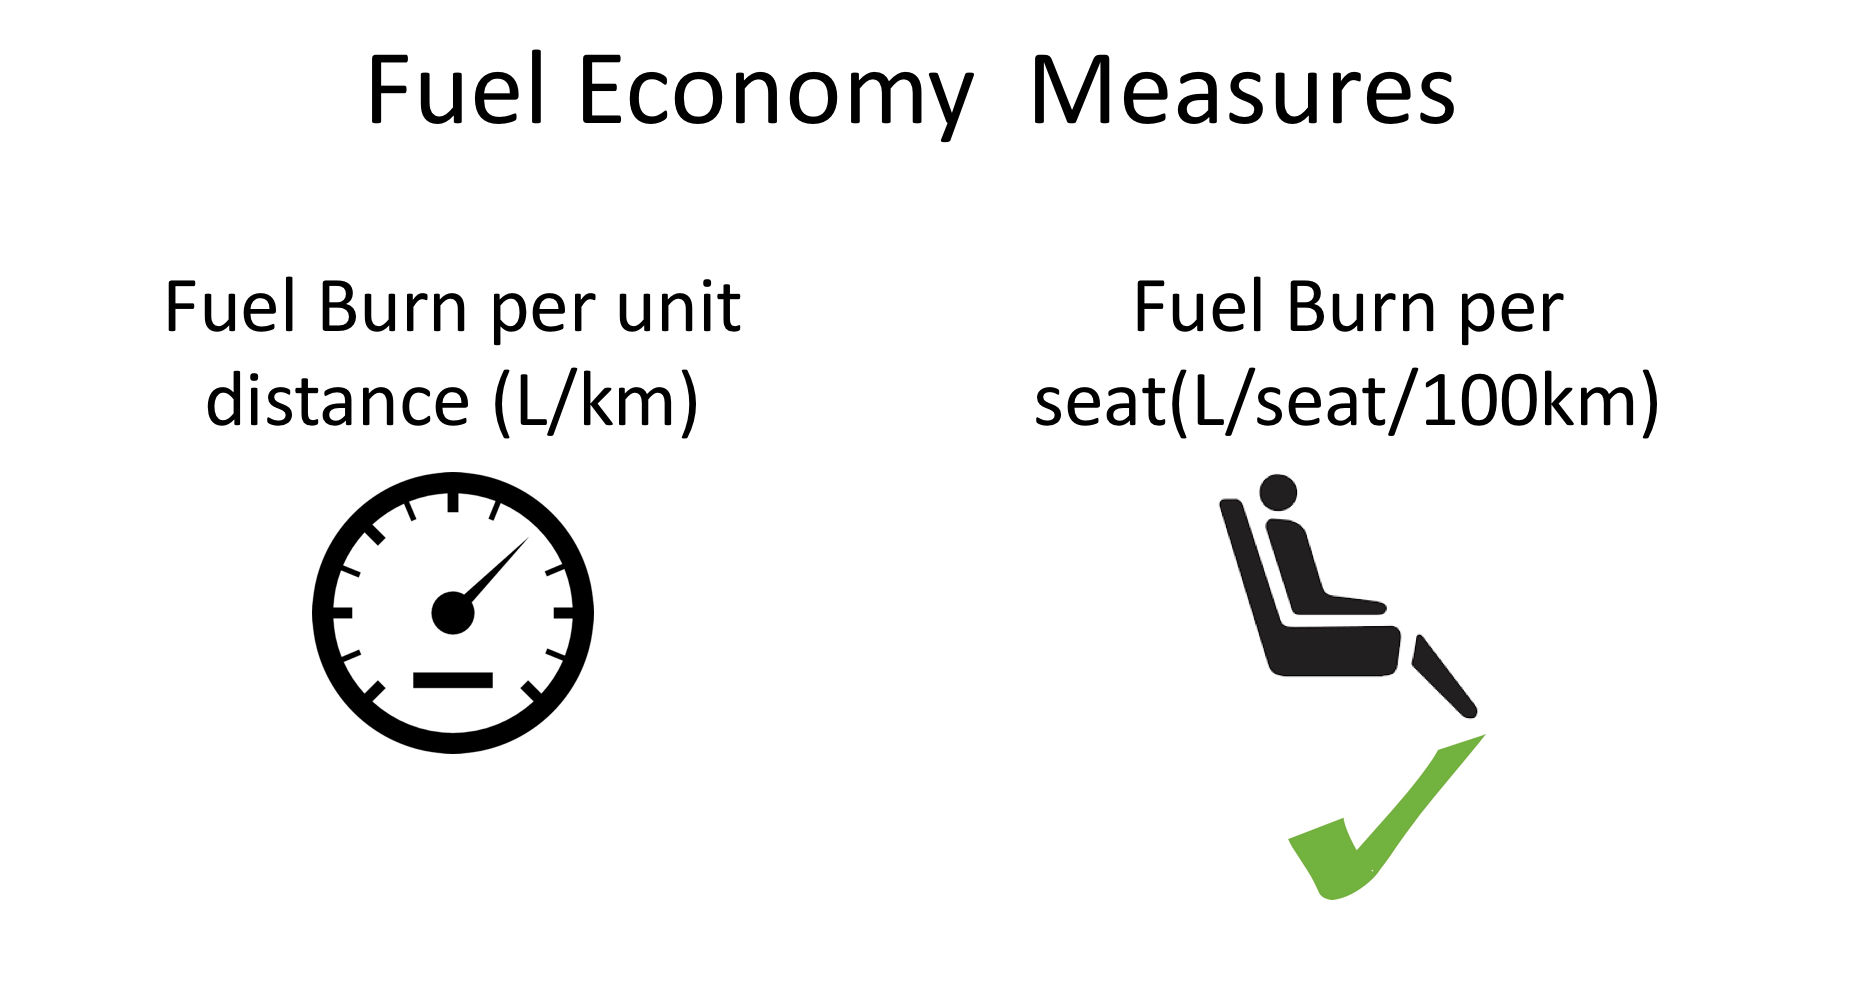

In [3]:
Image('./image4.png')

## What affects fuel consumption? 

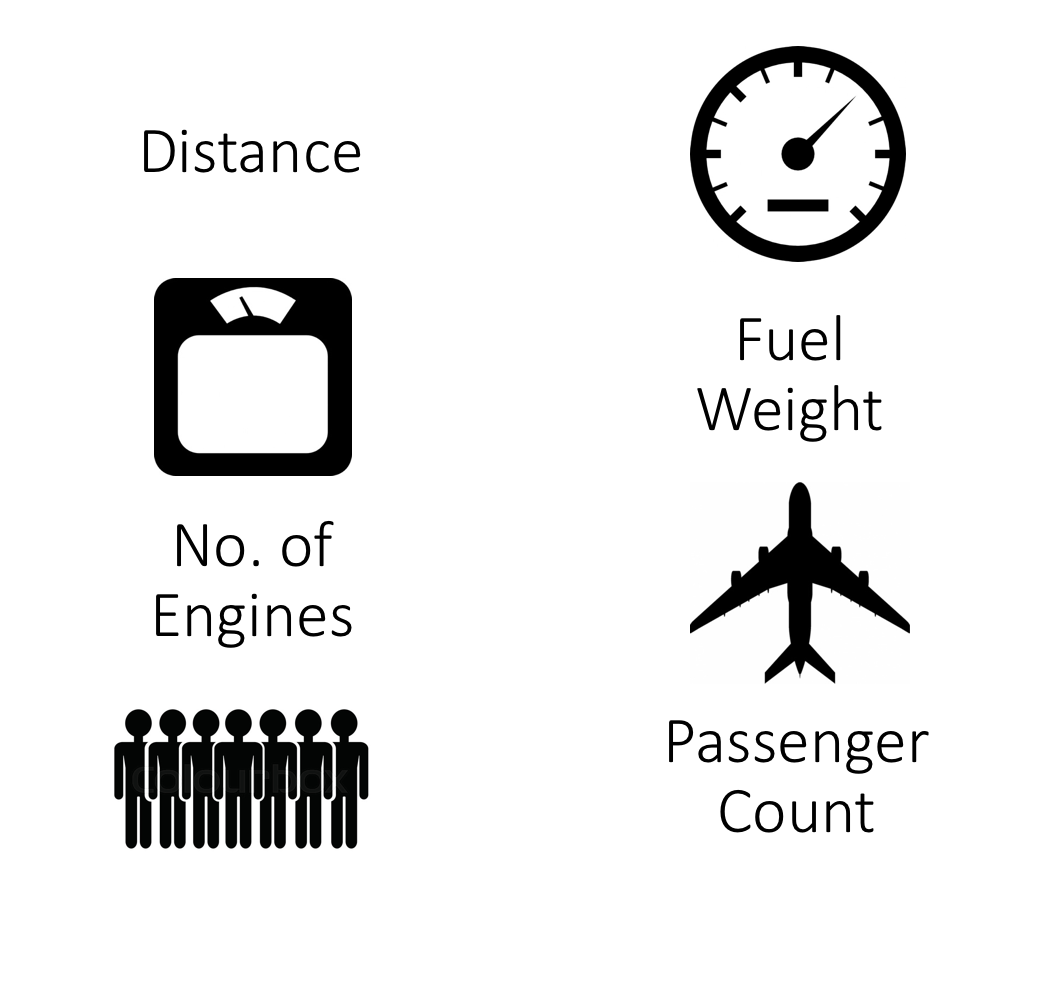

In [4]:
Image('./image5.png')

### Factors affecting fuel conusmption in aircrafts
The airline industry tends to contribute dispropportionately to the cause of global warming. A typical long haul flight can consume well over a hundred tons of fuel. Certain Characteristics of aircraft fuel consumption are 
* **Distance - ** Fuel consumption is maximum during take-off. As the distance travelled increases, the fuel economy increases, eventually resulting in a "sweet-spot". This is different for each variety of aircraft. 
* **Weight - **But, beyond the sweet-spot, the fuel economy begins to reduce again because of the additional weight virtue of the additional fuel that is required to travel longer distances.
* **Engine configuration - **Twin engine aircrafts tend to be more fuel efficient than quad engine aircrafts.
* **Number of passengers - **The best fuel efficiency is achieved when the aircraft is filled with passengers to it's capacity.

#### In the image below, we can see the fuel economy curve of a Boeing 777-200 aircraft - High fuel consumption immidiately after take-off, followed by the sweet-spot and then the eventual increase as range increases. 

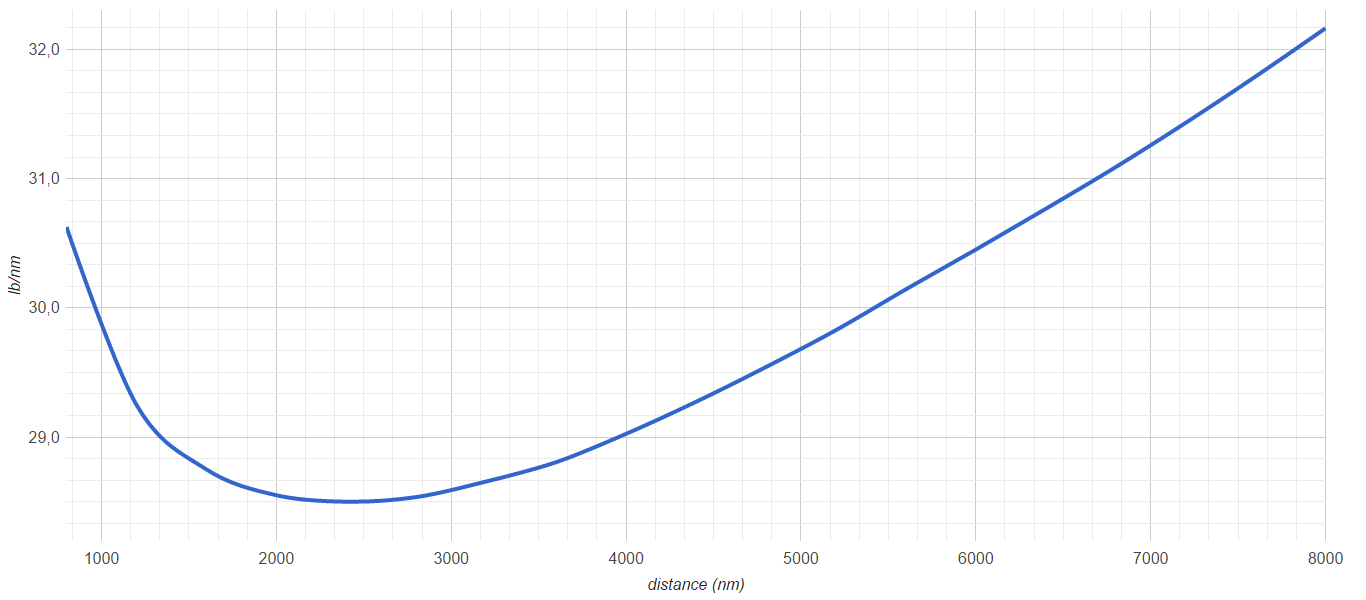

In [5]:
Image("./image1.png")

**The fuel efficiency is measured in no. of litres of fuel consumed per seat per 100 km.**

#### Please note - All measurements will be made in the metric system.

In [6]:
import pandas as pd
import numpy as np
import re
from geopy.distance import great_circle
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from IPython.display import Image
import seaborn as sns
import os
import datetime
import json
import requests
from lxml import html
from collections import OrderedDict
import argparse
import warnings
warnings.filterwarnings('ignore')

### We begin by scraping fuel economy numbers from a Wikipedia page

#### Cleaning fuel economy numbers
* Column for first flight can be dropped as it represents no additional value.
* The numerical value of fuel burn and fuel per seat needs to be extracted and converted to floating points.
* The seats column can be dropped as airlines fly different configurations of these airplanes and the numbers become pointless 
* Model values need to be cleaned i.e the testing range needs to be omitted.

In [7]:
# Import fuel economy numbers for distances under 560 km
fuel_econ_560 = pd.read_html('https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft',header=0)[0]
fuel_econ_560

,Model,First flight,Seats,Fuel burn,Fuel per seat
0,ATR 42-500,1995,48,1.26 kg/km (4.5 lb/mi),3.15 L/100 km (75 mpg‑US)[26]
1,ATR 72-500,1997,70,1.42 kg/km (5.0 lb/mi),2.53 L/100 km (93 mpg‑US)[26]
2,Beechcraft 1900D (226 nm),1982,19,1.00 kg/km (3.56 lb/mi),6.57 L/100 km (35.8 mpg‑US)[27]
3,Bombardier Dash 8 Q400,1998,78,2.16 kg/km (7.7 lb/mi),3.46 L/100 km (68.0 mpg‑US)[28]
4,Dornier 228,1981,19,0.94 kg/km (3.3 lb/mi),6.22 L/100 km (37.8 mpg‑US)[29]
5,Dornier 328,1991,30,1.10 kg/km (3.91 lb/mi),4.57 L/100 km (51.5 mpg‑US)[30]
6,Embraer Brasilia,1983,30,0.92 kg/km (3.3 lb/mi),3.82 L/100 km (61.6 mpg‑US)[31]
7,Pilatus PC-12 (500 nm),1991,9,0.41 kg/km (1.5 lb/mi),5.66 L/100 km (41.6 mpg‑US)[32]
8,Saab 340,1983,32,1.1 kg/km (3.9 lb/mi),4.29 L/100 km (54.8 mpg‑US)[33]
9,Saab 2000,1992,50,1.75 kg/km (6.2 lb/mi),4.39 L/100 km (53.6 mpg‑US)[34]


In [8]:
# Import fuel economy numbers for distances under 560 km
fuel_econ_560.drop(['First flight', 'Seats'], axis = 1, inplace=True)
fuel_econ_560['Model'] = fuel_econ_560['Model'].str.replace('\s\(.*\)', '')
fuel_econ_560['Fuel burn'] = fuel_econ_560['Fuel burn'].str.extract('(\d+.\d+)', expand=False ).astype(float)
fuel_econ_560['Fuel per seat'] = fuel_econ_560['Fuel per seat'].str.extract('(\d+.\d+)', expand=False).astype(float)
fuel_econ_560

,Model,Fuel burn,Fuel per seat
0,ATR 42-500,1.26,3.15
1,ATR 72-500,1.42,2.53
2,Beechcraft 1900D,1.00,6.57
3,Bombardier Dash 8 Q400,2.16,3.46
4,Dornier 228,0.94,6.22
5,Dornier 328,1.10,4.57
6,Embraer Brasilia,0.92,3.82
7,Pilatus PC-12,0.41,5.66
8,Saab 340,1.10,4.29
9,Saab 2000,1.75,4.39


#### This works, but the above method is tedious and inefficient, let's write a function to make things easier and cleaner.

In [9]:
def clean_fuel_econ(i):
    df_fuel = pd.read_html('https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft',header=0)[i]
    try:
        df_fuel.drop(['First flight', 'Seats', 'Sector'], axis = 1, inplace=True)
    except ValueError: #Some tables do not have the Sector column and might throw a ValueError
        df_fuel.drop(['First flight', 'Seats'], axis = 1, inplace=True)
    df_fuel.columns = ['Model', 'Fuel burn', 'Fuel per seat']
    df_fuel['Model'] = df_fuel['Model'].str.replace('\s\(.*\)', '')
    df_fuel['Fuel burn'] = df_fuel['Fuel burn'].str.extract('(\d+.\d+)', expand=False ).astype(float)
    df_fuel['Fuel per seat'] = df_fuel['Fuel per seat'].str.extract('(\d+.\d+)', expand=False).astype(float)
    return df_fuel

In [10]:
# Scrape data; The tables are in the same page and just iterating over the scraped tables is good enough to get the 
# different tables. All we need to do is pass the index
fuel_econ_560 = clean_fuel_econ(0)
fuel_econ_1120 = clean_fuel_econ(1)
fuel_econ_1900 = clean_fuel_econ(2)
fuel_econ_5600 = clean_fuel_econ(3)
fuel_econ_14100 = clean_fuel_econ(4)

In [11]:
# Checking for formatting
fuel_econ_560.head(5)

,Model,Fuel burn,Fuel per seat
0,ATR 42-500,1.26,3.15
1,ATR 72-500,1.42,2.53
2,Beechcraft 1900D,1.00,6.57
3,Bombardier Dash 8 Q400,2.16,3.46
4,Dornier 228,0.94,6.22


In [12]:
fuel_econ_1120.head(5)

,Model,Fuel burn,Fuel per seat
0,Airbus A319neo,3.37,2.92
1,Airbus A319neo,2.82,2.82
2,Airbus A320neo,2.79,2.25
3,Airbus A321neo,3.30,2.19
4,Boeing 737-300,3.49,3.46


In [13]:
fuel_econ_1900.head(5)

,Model,Fuel burn,Fuel per seat
0,Airbus A319,2.93,2.95
1,Airbus A319Neo,2.40,1.93
2,Airbus A320,3.13,2.61
3,Airbus A321-200,3.61,2.50
4,Airbus A330-200,5.60,2.37


In [14]:
fuel_econ_5600.head(5)

,Model,Fuel burn,Fuel per seat
0,Airbus A320,2.91,2.43
1,Airbus A321NeoLR,2.99,2.43
2,Airbus A330-200,NaN,3.11
3,Airbus A330-300,6.25,2.98
4,Airbus A330neo-900,NaN,2.42


In [15]:
fuel_econ_14100.head(5)

,Model,Fuel burn,Fuel per seat
0,Airbus A330-200,6.40,3.32
1,Airbus A330neo-800,5.45,2.75
2,Airbus A330neo-900,5.94,2.48
3,Airbus A340-300,7.32,3.49
4,Airbus A350-900,6.03,2.39


### The airports dataset is imported next

#### Cleaning the airports dataset
* The airports dataset from openflights contained missing entries, a newer more complete dataset has been obtained from [here](https://github.com/mwgg/Airports "MWGG Airports dataset").
* Airport data is contained in a json file. The dataset contains over 28K entries, almost every airstrip in the world. The redundant data can be identified by checking for the presence of an IATA (International Air Transport Association) code. IATA codes are not allocated for very small private airports or grass airstrips.
* Airports without an IATA code can be elminiated from further analysis. 
* The dataframe uses ICAO codes as the index by default. This index needs to be dropped and re-initialized to a series.
* Not all airports have information like State or Province, but this is not required for analysis.
* Feilds required are the IATA codes, latitudes and longitudes.

In [16]:
# Import routes datas
airports = pd.read_json('./../Data/airports.json')
airports

,00AK,00AL,00AZ,00CA,00CO,00FA,00FL,00GA,00ID,00IL,...,ZYMD,ZYMH,ZYQQ,ZYTH,ZYTL,ZYTN,ZYTX,ZYXC,ZYYJ,ZYYY
city,Anchor Point,Harvest,Cordes,Barstow,Briggsdale,Bushnell,Okeechobee,Lithonia,Clark Fork,Polo,...,Mudanjiang,Mohe,Qiqihar,Tahe,Dalian,Tonghua,Shenyang,,Yanji,Shenyang
country,US,US,US,US,US,US,US,US,US,US,...,CN,CN,CN,CN,CN,CN,CN,CN,CN,CN
elevation,450,820,3810,3038,4830,53,35,700,2064,840,...,883,1836,477,1240,107,1200,198,30,624,0
iata,,,,,,,,,,,...,MDG,OHE,NDG,,DLC,TNH,SHE,XEN,YNJ,
icao,00AK,00AL,00AZ,00CA,00CO,00FA,00FL,00GA,00ID,00IL,...,ZYMD,ZYMH,ZYQQ,ZYTH,ZYTL,ZYTN,ZYTX,ZYXC,ZYYJ,ZYYY
lat,59.9492,34.8648,34.3056,35.3505,40.6222,28.6455,27.2309,33.7675,48.1453,41.9784,...,44.5241,52.9128,47.2396,52.2244,38.9657,42.2539,41.6398,40.5803,42.8828,41.7844
lon,-151.696,-86.7703,-112.165,-116.888,-104.344,-82.219,-80.9692,-84.0683,-116.214,-89.5604,...,129.569,122.43,123.918,124.72,121.539,125.703,123.483,120.698,129.451,123.496
name,Lowell Field,Epps Airpark,Cordes Airport,Goldstone /Gts/ Airport,Cass Field,Grass Patch Airport,River Oak Airport,Lt World Airport,Delta Shores Airport,Hammer Airport,...,Mudanjiang Hailang International Airport,Gu-Lian Airport,Qiqihar Sanjiazi Airport,Tahe Airport,Zhoushuizi Airport,Tonghua Sanyuanpu Airport,Taoxian Airport,Xingcheng Air Base,Yanji Chaoyangchuan Airport,Shenyang Dongta Airport
state,Alaska,Alabama,Arizona,California,Colorado,Florida,Florida,Georgia,Idaho,Illinois,...,Heilongjiang,Heilongjiang,Heilongjiang,Heilongjiang,Liaoning,Jilin,Liaoning,Liaoning,Jilin,Liaoning
tz,America/Anchorage,America/Chicago,America/Phoenix,America/Los_Angeles,America/Denver,America/New_York,America/New_York,America/New_York,America/Los_Angeles,America/Chicago,...,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai,Asia/Shanghai


In [17]:
# Transpose dataframe
airports = airports.T
airports = airports[airports['iata'] != ''] # Delete smaller airstrips without IATA code
airports = airports.drop_duplicates('iata') # Delete airports which have been upgraded
airports.reset_index(drop=True, inplace=True) # Reset index

In [18]:
# Check cleaned data
airports.head(15)

,city,country,elevation,iata,icao,lat,lon,name,state,tz
0,Icy Bay,US,50,ICY,19AK,59.969,-141.662,Icy Bay Airport,Alaska,America/Anchorage
1,Hogatza,US,534,HGZ,2AK6,66.2161,-155.669,Hog River Airport,Alaska,America/Anchorage
2,Blakely Island,US,66,BYW,38WA,48.579,-122.826,Blakely Island Airport,Washington,America/Los_Angeles
3,Bradford,US,808,BDF,3IS8,41.2309,-89.6157,Rinkenberger Restricted Landing Area,Illinois,America/Chicago
4,Belle Chasse,US,0,BCS,65LA,29.8661,-90.0222,Southern Seaplane Airport,Louisiana,America/Chicago
5,Blackwell,US,1054,BWL,6OK6,36.7959,-97.317,Earl Henry Airport,Oklahoma,America/Chicago
6,Corolla,US,16,DUF,7NC2,36.2535,-75.7885,Pine Island Airport,North-Carolina,America/New_York
7,Fort Bragg,US,71,FOB,82CL,39.4743,-123.796,Fort Bragg Airport,California,America/Los_Angeles
8,Alexander City,US,686,ALX,ADDE,32.9147,-85.963,Thomas C Russell Field,Alabama,America/Chicago
9,Bila,SB,23,AFT,AGAF,-9.19139,160.949,Afutara Aerodrome,Malaita,Pacific/Guadalcanal


In [19]:
# Let's check if we can see airports catering to the DMV area
airports[(airports['iata'] == 'IAD')|(airports['iata'] == 'BWI')|(airports['iata'] == 'DCA')]

,city,country,elevation,iata,icao,lat,lon,name,state,tz
2124,Baltimore,US,146,BWI,KBWI,39.1754,-76.6683,Baltimore/Washington International Thurgood Ma...,Maryland,America/New_York
2188,Washington,US,15,DCA,KDCA,38.8521,-77.0377,Ronald Reagan Washington National Airport,Virginia,America/New_York
2327,Washington,US,312,IAD,KIAD,38.9445,-77.4558,Washington Dulles International Airport,Virginia,America/New_York


### Importing the routes that airlines fly to
* The routes dataset contains all the routes that each of the airlines fly. This is part of the openflights dataset.
* The data contains the 2 character operator code in the column "Airline" that is used to identify airlines. eg - 'AA' for Ameircan airlines. These are internationally accepted. 
* Each airline has unique "Airline_ID", that is used to local to the dataset and can be deleted. 
* We'll be using the IATA codes of airports to identify them. Each route has a "Source_IATA" that is the IATA code of the source airport and the destination airport is represented in the "Dest_IATA" column.
* The "Equipment" column contains information about the type of aircraft that is being used to service the route. 
* The "Aircraft" column contains the details about the family of the equipment. 

In [20]:
# Import routes that airlines fly to
routes = pd.read_csv('./../../../Airline_Analysis/data/routes.csv', delimiter=',')

In [21]:
routes.head(10)

,Airline,Airline_ID,Source_IATA,Source_ID,Dest_IATA,Dest_ID
0,2B,410,AER,2965,KZN,2990
1,2B,410,ASF,2966,KZN,2990
2,2B,410,ASF,2966,MRV,2962
3,2B,410,CEK,2968,KZN,2990
4,2B,410,CEK,2968,OVB,4078
5,2B,410,DME,4029,KZN,2990
6,2B,410,DME,4029,NBC,6969
7,2B,410,DME,4029,TGK,\N
8,2B,410,DME,4029,UUA,6160
9,2B,410,EGO,6156,KGD,2952


In [22]:
# Drop the Airline_ID, Source_ID and Dest_ID columns
routes.drop(['Airline_ID', 'Source_ID', 'Dest_ID'], axis=1, inplace=True)

In [23]:
routes.head(10)

,Airline,Source_IATA,Dest_IATA
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB
5,2B,DME,KZN
6,2B,DME,NBC
7,2B,DME,TGK
8,2B,DME,UUA
9,2B,EGO,KGD


### Functions for analyzing fleet operations
**fleet_distance(airline_code) - ** This function is used to generate a dataframe that contains all the distances of all the routes an airline. The input argument is the 2 character Airline call sign. The function iterates through all the routes, sends the source and destination IATA codes to the get_dist function which returns the distance of the given route.<br>
**get_dist(src,dst)** - This function takes in the source and destination IATA codes as arguments, fetches the latitude and longitude of the airports, computes the distance between the airports and then returns the distance in km. The geopy module is used to compute the great circle distance between the locations. 

In [24]:
def fleet_distance(airline_code):
    fleet_dist_arr = []
    for i, row in routes.iterrows():
        if row['Airline'] == airline_code :
            dist = get_dist(row['Source_IATA'], row['Dest_IATA'])
            fleet_dist_arr.append(dist)
    fleet_dist_arr = np.unique(fleet_dist_arr);
    return pd.DataFrame(fleet_dist_arr)

def get_dist(src, dst):
    try:
        dst_index = np.asscalar(np.where(airports['iata'] == dst)[0])
        src_index = np.asscalar(np.where(airports['iata'] == src)[0])
        src = (airports['lat'][src_index], airports['lon'][src_index])
        dst = (airports['lat'][dst_index], airports['lon'][dst_index])
        return great_circle(src, dst).km
    except : 
        return 500;

### Checking the get_dist function
Let's use the fucntion to calculate the distance from JFK to IAD. We'll be using the calculator from [travelmath](https://www.travelmath.com/flying-distance/from/JFK/to/IAD) as a comparison.

In [25]:
print("Distance from JFK to IAD is ", get_dist('IAD', 'JFK'), "km.")

Distance from JFK to IAD is  366.4231146189811 km.


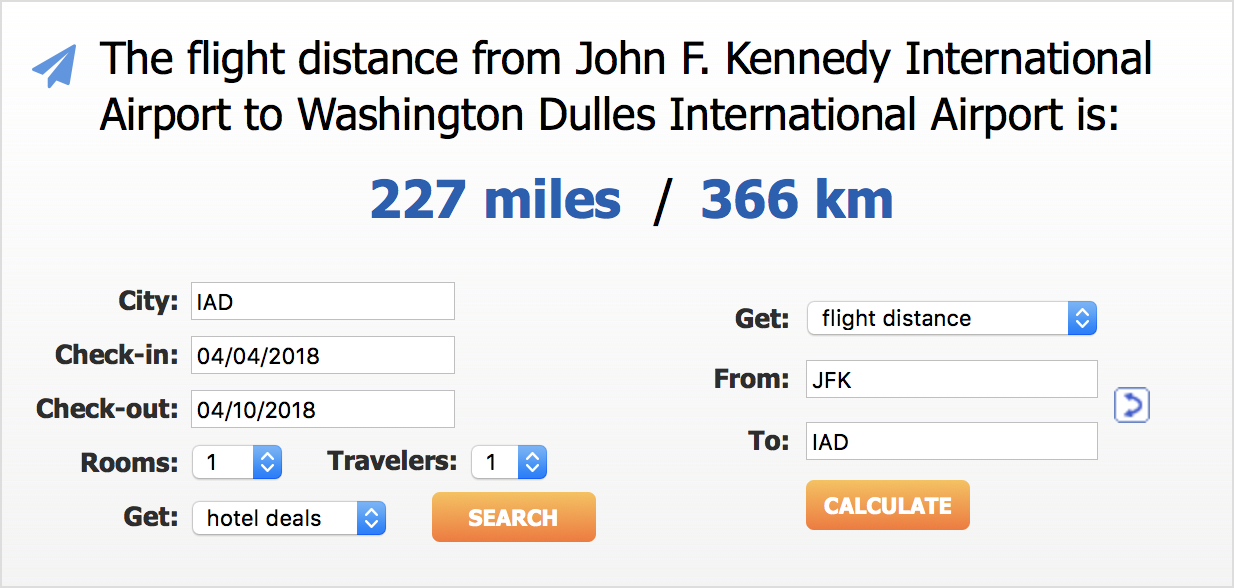

In [26]:
Image("./image2.png")

### Preliminary Fleet Analysis
By comparing the distance histograms of two carries - American Airlines and Emirates, we can see the significant difference in the distance of routes being served. 

**American Airlines -** The largest carrier in the US (and the world) offers a large number of short domestic flights. The number of flights reduce sharply with the increased distance. This strongly correlates with the point to point transportation model that American uses. Interestingly, the number of flights in the 6000 km range increase, this can be attributed to two factors - 
* Coast to coast domestic flights in the US.
* Transatlantic flights from the West Coast to Western Europe.

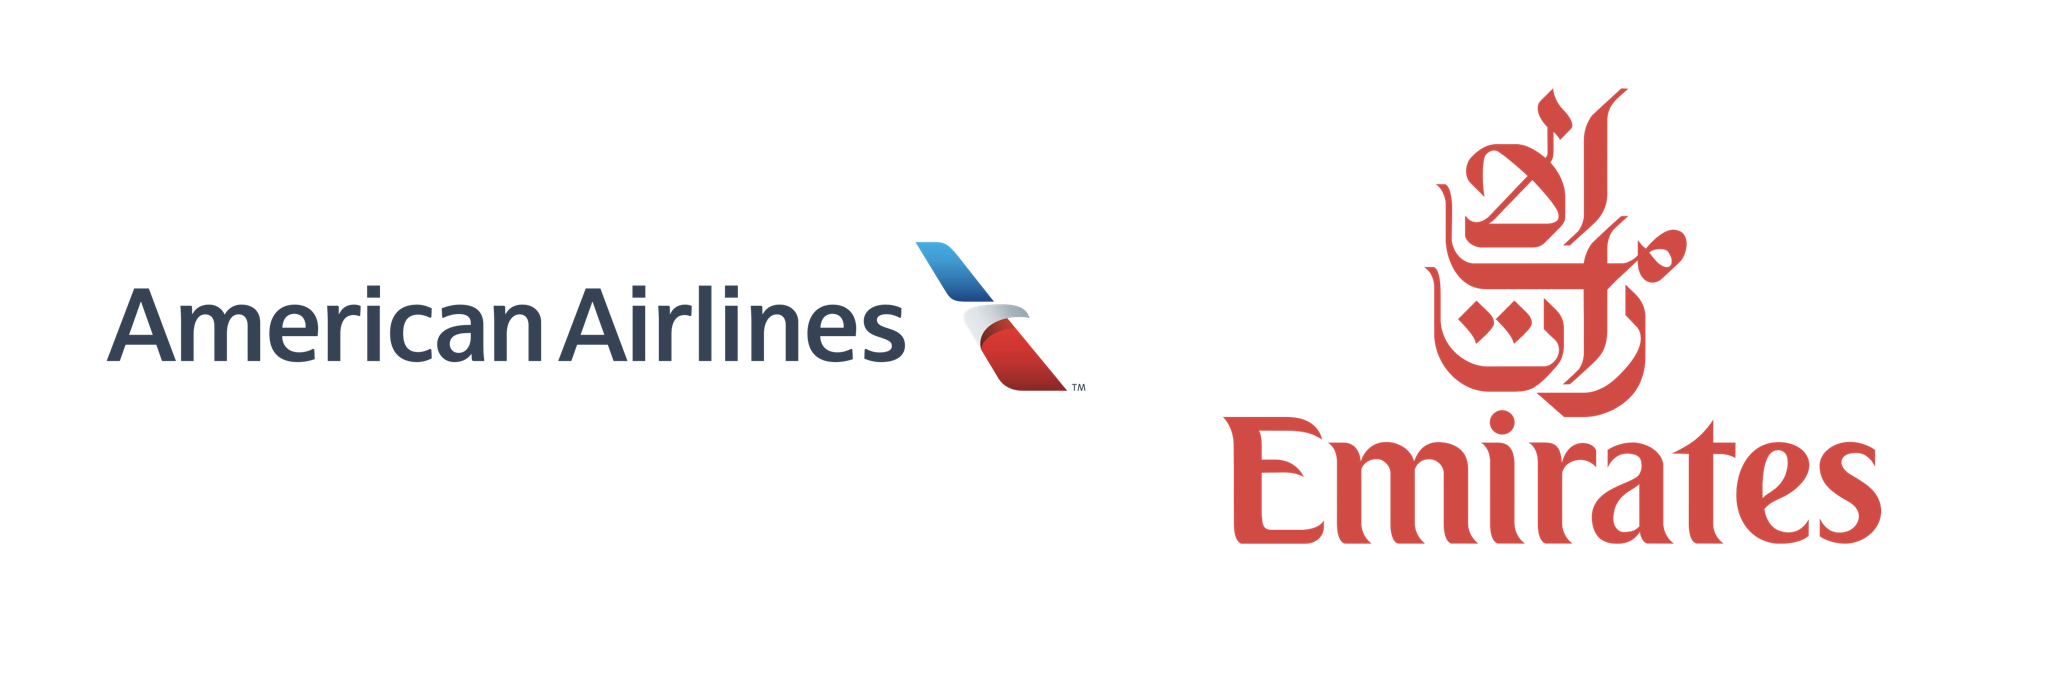

In [27]:
Image("./image3.png")

In [28]:
# Create distance histogram just by passing the Airline Code
fleet_dist_American = fleet_distance('AA');
fleet_dist_Emirates = fleet_distance('EK')

**Emirates -** Emirates operates a significantly higher **percentage** of long haul flights. The average Emirates flight is 4463.81 km in distance. 

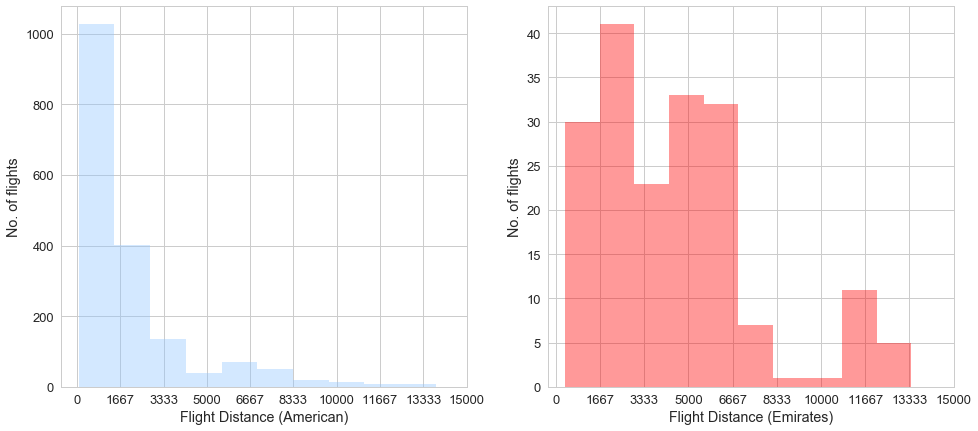

In [29]:
# Set background style to "White Grid", 
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.3)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(16, 7))
#sns.despine()

# Plot a simple histogram with binsize determined automatically
d = sns.distplot(fleet_dist_American, bins=10, kde=False, axlabel='Flight Distance (American)', ax=axes[0])
d.set(ylabel='No. of flights', xticks=np.linspace(0,15000, 10));

# Plot a kernel density estimate and rug plot
e=sns.distplot(fleet_dist_Emirates, bins=10, kde=False, axlabel='Flight Distance (Emirates)', color='Red', ax=axes[1])
e.set(ylabel='No. of flights', xticks=np.linspace(0,15000, 10));

In [30]:
fleet_dist_American.describe()

,0
count,1776.000000
mean,2007.565327
std,2282.441862
min,63.469234
25%,595.792152
50%,1176.124789
75%,2355.095373
max,13812.068643


In [31]:
fleet_dist_Emirates.describe()

,0
count,184.000000
mean,4464.570511
std,3114.628655
min,348.577331
25%,2020.511058
50%,4159.296169
75%,5860.624697
max,13403.852438


# Point to point fuel efficiency (Scrape data from Expedia)
* The efficiency of a trip is computed by taking data from expedia. 
* Upon entering the source and destination IATA codes (even works with place names provided there are no conflicts i.e. multiple airports).  

#### Why do this instead of using the openflights dataset?
* It was not possible to get accurate information on connecting flights from the openflights dataset.
* Codeshare aggrements caused havoc and were not well represented.
* Just because there is a possible one-point or two-point connection from A to B does not mean there is an airline servicing it. 
* Allows for entering destination and source location names as strings instead of the IATA codes. 

#### Problems it solves
* It is now possible to get more detailed information of connecting flights, including the model of the airplane, the duration and ticket prices.
* Ticket price also more comprehensive analysis and analyse trade-offs between ticket price and fuel economy.

#### Enter the source airport

In [47]:
# Get source airport
print("Enter Source Aiport : ")
src_get = input()

Enter Source Aiport : 
IAD


#### Enter destination airport

In [48]:
# Get destination airport
print("Enter Destination Aiport : ")
dst_get = input()

Enter Destination Aiport : 
BLR


#### Set a booking date a month from now

In [34]:
# Set booking date to a month from now
book_date = datetime.date.today()
book_date = str(book_date + datetime.timedelta(days=30))
book_date = datetime.datetime.strptime(book_date, '%Y-%m-%d')
book_date = book_date.strftime('%m/%d/%Y')

## This code was a seperate file that was being invoked by a magic function in the demonstration notebook

In [137]:
# Function to get route details from Expedia
def get_expedia(source,destination,date):
    for i in range(5):
        try: # Expedia has a very simple url structure that we can take advatage of
            url = "https://www.expedia.com/Flights-Search?trip=oneway&leg1=from:{0},to:{1},departure:{2}TANYT&passengers=adults:1,children:0,seniors:0,infantinlap:Y&options=cabinclass%3Aeconomy&mode=search&origref=www.expedia.com".format(source,destination,date)
            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
            response = requests.get(url, headers=headers, verify=False)
            parser = html.fromstring(response.text)
            json_data_xpath = parser.xpath("//script[@id='cachedResultsJson']//text()")
            raw_json =json.loads(json_data_xpath[0] if json_data_xpath else '')
            flight_data = json.loads(raw_json["content"])
            #print(flight_data)
            flight_info  = OrderedDict() 
            lists=[]

            for i in flight_data['legs'].keys():
                total_distance =  flight_data['legs'][i].get("formattedDistance",'')
                exact_price = flight_data['legs'][i].get('price',{}).get('totalPriceAsDecimal','')

                departure_location_airport = flight_data['legs'][i].get('departureLocation',{}).get('airportLongName','')
                departure_location_city = flight_data['legs'][i].get('departureLocation',{}).get('airportCity','')
                departure_location_airport_code = flight_data['legs'][i].get('departureLocation',{}).get('airportCode','')

                arrival_location_airport = flight_data['legs'][i].get('arrivalLocation',{}).get('airportLongName','')
                arrival_location_airport_code = flight_data['legs'][i].get('arrivalLocation',{}).get('airportCode','')
                arrival_location_city = flight_data['legs'][i].get('arrivalLocation',{}).get('airportCity','')
                airline_name = flight_data['legs'][i].get('carrierSummary',{}).get('airlineName','')

                no_of_stops = flight_data['legs'][i].get("stops","")
                flight_duration = flight_data['legs'][i].get('duration',{})
                flight_hour = flight_duration.get('hours','')
                flight_minutes = flight_duration.get('minutes','')
                flight_days = flight_duration.get('numOfDays','')

                if no_of_stops==0:
                    stop = "Nonstop"
                else:
                    stop = str(no_of_stops)+' Stop'

                total_flight_duration = "{1} hours {2} minutes".format(flight_days,flight_hour,flight_minutes)
                departure = departure_location_airport_code+", "+departure_location_city
                arrival = arrival_location_airport_code+", "+arrival_location_city
                carrier = flight_data['legs'][i].get('timeline',[])[0].get('carrier',{})
                plane = carrier.get('plane','')
                plane_code = carrier.get('planeCode','')
                formatted_price = "{0:.2f}".format(exact_price)

                if not airline_name:
                    airline_name = carrier.get('operatedBy','')

                timings = []
                for timeline in  flight_data['legs'][i].get('timeline',{}):
                    if 'departureAirport' in timeline.keys():
                        departure_airport = timeline['departureAirport'].get('code','')
                        departure_time = timeline['departureTime'].get('time','')
                        arrival_airport = timeline.get('arrivalAirport',{}).get('code','')
                        arrival_time = timeline.get('arrivalTime',{}).get('time','')
                        plane_code = timeline['carrier'].get('planeCode','')
                        plane = timeline['carrier'].get('plane','')
                        #print(plane_code)
                        flight_timing = {
                                            'departure_airport':departure_airport,
                                            'departure_time':departure_time,
                                            'arrival_airport':arrival_airport,
                                            'arrival_time':arrival_time,
                                            'plane_code' :plane_code,
                                            'plane' :plane
                        }
                        timings.append(flight_timing)

                flight_info={'stops':stop,
                    'ticket price':formatted_price,
                    'departure':departure,
                    'arrival':arrival,
                    'flight duration':total_flight_duration,
                    'airline':airline_name,
                    'timings':timings
                }
                lists.append(flight_info)
            sortedlist = sorted(lists, key=lambda k: k['ticket price'],reverse=False)
            sortedlist =  pd.DataFrame(sortedlist)
            sortedlist.drop_duplicates(['airline'],inplace=True)
            sortedlist = sortedlist[sortedlist['airline'] != '']
            return sortedlist

        except ValueError:
            print ("Retrying...")

        return {"error":"failed to process the page",}

In [118]:
ticks = get_expedia(src_get,dst_get,book_date)

In [119]:
# Display the scraped dataframe
ticks

,airline,arrival,departure,flight duration,stops,ticket price,timings
0,Etihad Airways,"BLR, Bengaluru","IAD, Washington",36 hours 55 minutes,2 Stop,1054.38,"[{'departure_airport': 'IAD', 'departure_time'..."
19,Emirates,"BLR, Bengaluru","IAD, Washington",30 hours 35 minutes,1 Stop,1086.65,"[{'departure_airport': 'IAD', 'departure_time'..."
22,Qatar Airways,"BLR, Bengaluru","IAD, Washington",20 hours 25 minutes,1 Stop,1111.51,"[{'departure_airport': 'IAD', 'departure_time'..."
23,Turkish Airlines,"BLR, Bengaluru","IAD, Washington",34 hours 0 minutes,2 Stop,1144.38,"[{'departure_airport': 'IAD', 'departure_time'..."
25,Jet Airways,"BLR, Bengaluru","IAD, Washington",30 hours 35 minutes,2 Stop,1244.11,"[{'departure_airport': 'IAD', 'departure_time'..."
29,KLM,"BLR, Bengaluru","IAD, Washington",47 hours 5 minutes,2 Stop,938.59,"[{'departure_airport': 'IAD', 'departure_time'..."


#### To move the analysis further, we can see further analysis of each of the legs of the trip.
* We can see the equipment/aircraft being used to service each trip. 
* We have the IATA codes for each trip. 
* Distance and fuel used can now be calculated from this.

In [51]:
ticks.timings[22]

[{'arrival_airport': 'DOH',
  'arrival_time': '4:00pm',
  'departure_airport': 'IAD',
  'departure_time': '8:25pm',
  'plane': 'BOEING 777-300ER',
  'plane_code': '77W'},
 {'arrival_airport': 'BLR',
  'arrival_time': '2:20am',
  'departure_airport': 'DOH',
  'departure_time': '7:30pm',
  'plane': 'BOEING 777-300ER',
  'plane_code': '77W'}]

#### We can see that to go from Washington, DC to Bangalore, India; Qatar Airways offers the following option  - 
* The first leg is a flight from DC to Doha in Boeing 777-300ER.
* The second leg is from Doha to Bangalore, again in a Boeing 777-300ER.

#### Let's compute the fuel efficiency 
* The unit will be no. of litres of fuel consumed per passenger for various options that are available.  

In [39]:
def fuel_used (aircraft, distance):
    if distance <= 560:
        try:
            econ_index = np.asscalar((np.where(fuel_econ_560['Model'].str.contains(aircraft, na=False, case=False))[0])[0])
            return fuel_econ_560['Fuel per seat'][econ_index]*distance/100
        except:
            return fuel_econ_560['Fuel per seat'].mean()*distance/100
    elif distance <= 1120:
        try:
            econ_index = np.asscalar((np.where(fuel_econ_1120['Model'].str.contains(aircraft, na=False, case=False))[0])[0])
            return fuel_econ_1120['Fuel per seat'][econ_index]*distance/100
        except:
            return fuel_econ_1120['Fuel per seat'].mean()*distance/100
    elif distance <= 1900:
        try:
            econ_index = np.asscalar((np.where(fuel_econ_1900['Model'].str.contains(aircraft, na=False, case=False))[0])[0])
            return fuel_econ_1900['Fuel per seat'][econ_index]*distance/100
        except:
            return fuel_econ_1900['Fuel per seat'].mean()*distance/100
    elif distance <= 5600:
        try:
            econ_index = np.asscalar((np.where(fuel_econ_5600['Model'].str.contains(aircraft, na=False, case=False))[0])[0])
            return fuel_econ_5600['Fuel per seat'][econ_index]*distance/100
        except:
            return fuel_econ_5600['Fuel per seat'].mean()*distance/100
    else:
        try:
            econ_index = np.asscalar((np.where(fuel_econ_14100['Model'].str.contains(aircraft, na=False, case=False))[0])[0])
            return fuel_econ_14100['Fuel per seat'][econ_index]*distance/100
        except:
            return fuel_econ_14100['Fuel per seat'].mean()*distance/100

In [40]:
fuel_df= pd.DataFrame()
for index, row in ticks.iterrows(): 
    sum_fuel = 0
    for index_in, leg in enumerate(row['timings']):
        dep = leg['departure_airport']
        arr = leg['arrival_airport'] 
        dist = get_dist(dep, arr)
        plane =  leg['plane']
        plane = plane.strip('INDUSTRIE ')
        plane_code = leg['plane_code']
        trip_fuel = fuel_used(plane, dist)
        sum_fuel= sum_fuel+trip_fuel
        legs = {
            'departure_airport': dep,
            'arrival_airport': arr,
            'distance': dist,
            'plane': plane,
            'plane_code': plane_code,
            'fuel_consumed_per_pax':trip_fuel
        }
    print("Airline : ",row['airline'],' Fuel Consumed (litres)','%.2f'%sum_fuel)
    fuel_df = fuel_df.append(pd.DataFrame({'Airline': row['airline'], 
                                           'Fuel Consumed':sum_fuel,
                                           'Ticket Price':row['ticket price']}, 
                                          index=[0]), ignore_index=True)

Airline :  Etihad Airways  Fuel Consumed (litres) 434.68
Airline :  Emirates  Fuel Consumed (litres) 408.24
Airline :  Qatar Airways  Fuel Consumed (litres) 405.51
Airline :  Turkish Airlines  Fuel Consumed (litres) 402.51
Airline :  Jet Airways  Fuel Consumed (litres) 452.31
Airline :  KLM  Fuel Consumed (litres) 433.38


#### Let's make a function out of it

In [142]:
def compute_eff(ticket_df):
    fuel_df= pd.DataFrame()
    for index, row in ticket_df.iterrows(): 
        sum_fuel = 0
        for index_in, leg in enumerate(row['timings']):
            dep = leg['departure_airport']
            arr = leg['arrival_airport'] 
            dist = get_dist(dep, arr)
            plane =  leg['plane']
            plane = plane.strip('INDUSTRIE ')
            plane_code = leg['plane_code']
            trip_fuel = fuel_used(plane, dist)
            sum_fuel= sum_fuel+trip_fuel
            legs = {
                'departure_airport': dep,
                'arrival_airport': arr,
                'distance': dist,
                'plane': plane,
                'plane_code': plane_code,
                'fuel_consumed_per_pax':trip_fuel
            }
        fuel_df = fuel_df.append(pd.DataFrame({'Airline': row['airline'], 
                                               'Fuel Consumed':sum_fuel,
                                               'Ticket Price':float(row['ticket price'])}, 
                                              index=[0]), ignore_index=True)
    fuel_df = fuel_df.sort_values(['Ticket Price'], ascending=True)
    fuel_df.reset_index(inplace=True)
    return fuel_df

In [109]:
fuel_df = compute_eff(ticks)
fuel_df

,index,Airline,Fuel Consumed,Ticket Price
0,5,KLM,433.380575,938.59
1,0,Etihad Airways,434.677760,1054.38
2,1,Emirates,408.244658,1086.65
3,2,Qatar Airways,405.511686,1111.51
4,3,Turkish Airlines,402.510667,1144.38
5,4,Jet Airways,452.307263,1244.11


#### Let's plot a graph to trade-offs between cost and the fuel consumed per passenger

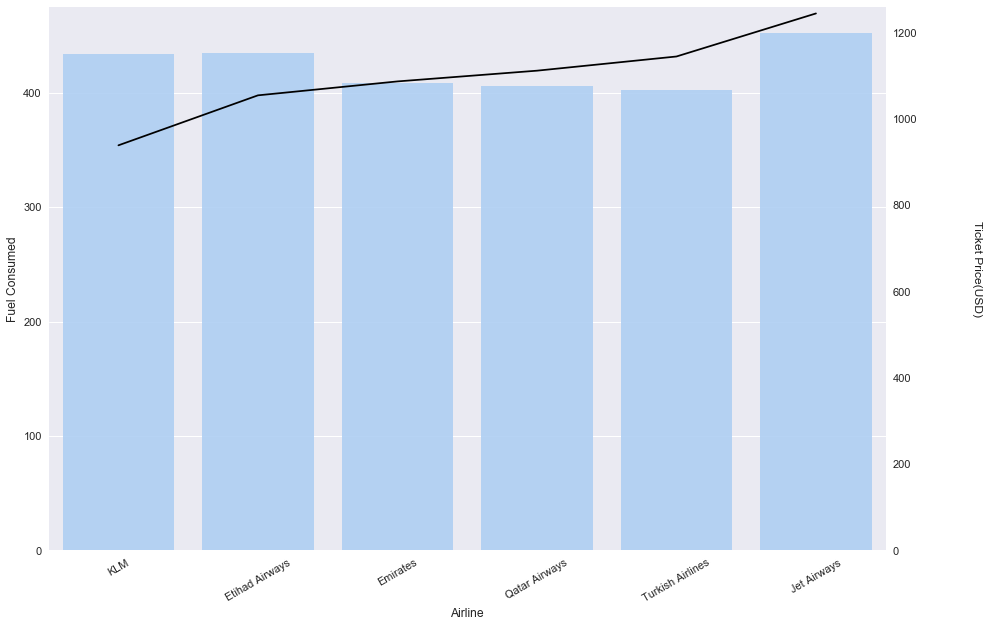

In [144]:
sns.set(font_scale=1.1)
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = sns.barplot("Airline",y="Fuel Consumed", data=fuel_df, color="#a2cffe", alpha=0.9)
ax2 = ax1.twinx()
ax2.plot(fuel_df["Ticket Price"], color = 'Black', alpha =1)
ax2.grid(False)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30);
ax2.text(len(fuel_df)*1.02, 0.6*fuel_df['Ticket Price'].max(), "Ticket Price(USD)", size=12, color='k', rotation=-90)
ax1.set_ylim(0,)
ax2.set_ylim(0,)
plt.show()

#### Making a function out of it 

In [145]:
def plot_fuel_price(fuel_df):
    sns.set(font_scale=1.1)
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax1 = sns.barplot("Airline",y="Fuel Consumed", data=fuel_df, color="#a2cffe", alpha=0.9)
    ax2 = ax1.twinx()
    ax2.plot(fuel_df["Ticket Price"], color = 'Black', alpha =1)
    ax2.grid(False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30);
    ax2.text(len(fuel_df)*1.02, 0.6*fuel_df['Ticket Price'].max(), "Ticket Price(USD)", size=12, color='k', rotation=-90)
    ax1.set_ylim(0,)
    ax2.set_ylim(0,)
    plt.show()

## Trying the function with just the place name

In [138]:
dc_joburg = get_expedia('IAD', 'Johannesburg', book_date)

In [139]:
dc_joburg

,airline,arrival,departure,flight duration,stops,ticket price,timings
0,Emirates,"JNB, Johannesburg","IAD, Washington",27 hours 55 minutes,1 Stop,1001.29,"[{'departure_airport': 'IAD', 'departure_time'..."
4,South African Airways,"JNB, Johannesburg","IAD, Washington",17 hours 5 minutes,1 Stop,1036.40,"[{'departure_airport': 'IAD', 'departure_time'..."
5,Endeavor Air DBA Delta Connection,"JNB, Johannesburg","IAD, Washington",20 hours 5 minutes,1 Stop,1048.78,"[{'departure_airport': 'IAD', 'departure_time'..."
6,Qatar Airways,"JNB, Johannesburg","IAD, Washington",31 hours 25 minutes,1 Stop,1129.51,"[{'departure_airport': 'IAD', 'departure_time'..."
8,Air China,"JNB, Johannesburg","IAD, Washington",31 hours 55 minutes,1 Stop,2083.38,"[{'departure_airport': 'IAD', 'departure_time'..."
9,Air Canada,"JNB, Johannesburg","IAD, Washington",40 hours 40 minutes,2 Stop,3118.23,"[{'departure_airport': 'IAD', 'departure_time'..."
19,United,"JNB, Johannesburg","IAD, Washington",34 hours 50 minutes,1 Stop,3131.59,"[{'departure_airport': 'IAD', 'departure_time'..."
29,Turkish Airlines,"JNB, Johannesburg","IAD, Washington",29 hours 25 minutes,1 Stop,754.38,"[{'departure_airport': 'IAD', 'departure_time'..."
30,Ethiopian Airlines,"JNB, Johannesburg","IAD, Washington",26 hours 55 minutes,1 Stop,783.02,"[{'departure_airport': 'IAD', 'departure_time'..."


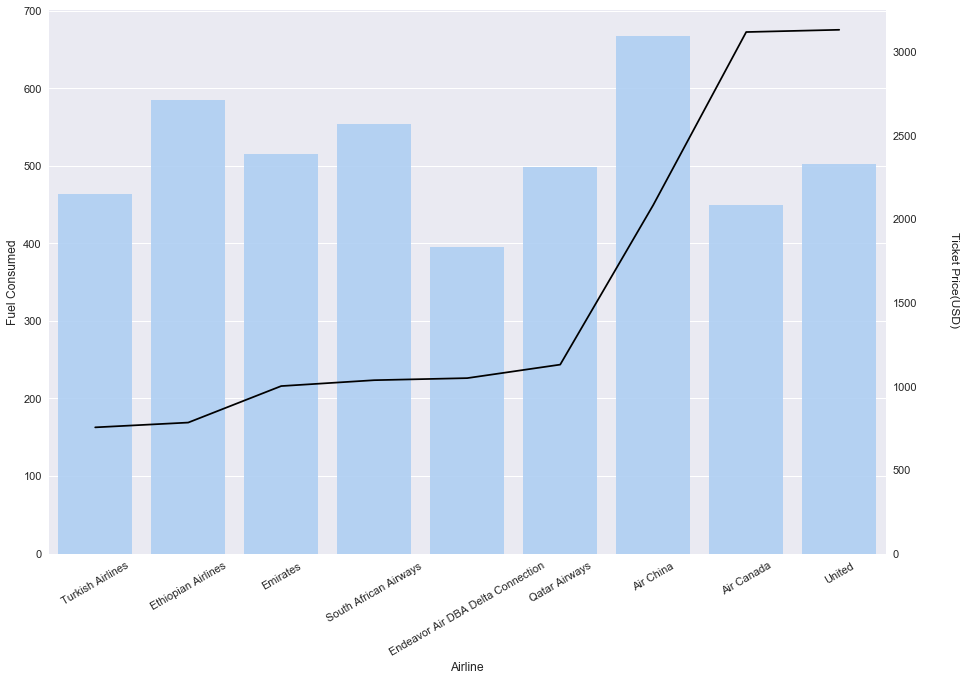

In [146]:
plot_fuel_price(compute_eff(dc_joburg))

### Additional time series analysis

In [164]:
def get_date_range(num_days):
    date_list = []
    for i in range (1,num_days):
        each_day = datetime.date.today()
        each_day = str(each_day + datetime.timedelta(days=i))
        each_day = datetime.datetime.strptime(each_day, '%Y-%m-%d')
        each_day = each_day.strftime('%m/%d/%Y')
        date_list.append(each_day)
    return date_list

In [173]:
date_range = get_date_range(5)

In [230]:
price_range = []
for each_day in get_date_range(30):
    temp_ticket = compute_eff(get_expedia('London', 'Singapore', each_day))
    price_range.append(temp_ticket['Ticket Price'].mean())

In [207]:
merged = zip(get_date_range(30), price_range)

In [219]:
merged = pd.concat([pd.DataFrame(get_date_range(30)),pd.DataFrame(price_range)], axis=1)
merged.columns = (['Date','Mean Price'])

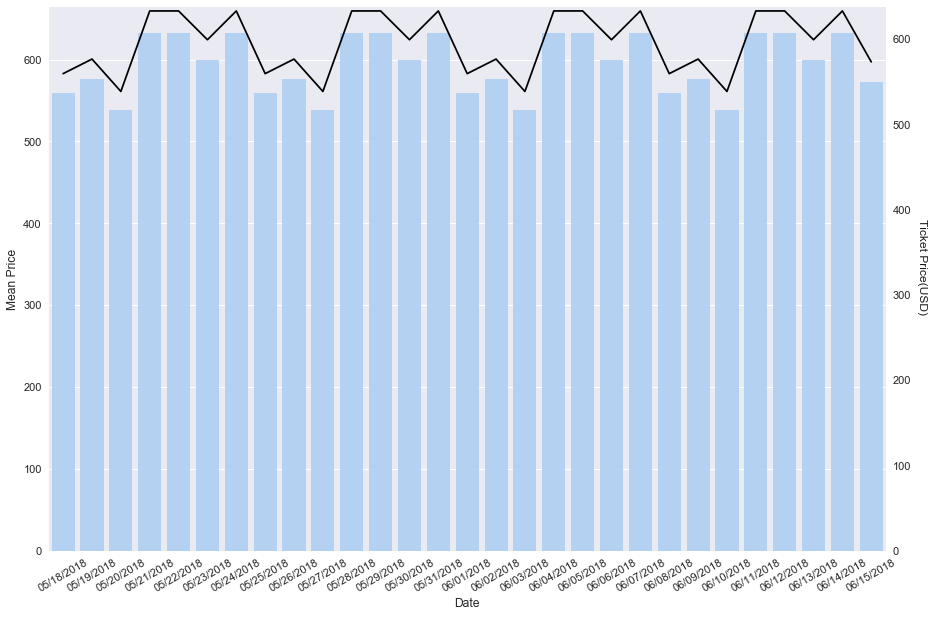

In [229]:
sns.set(font_scale=1.1)
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = sns.barplot("Date",y="Mean Price", data=merged, color="#a2cffe", alpha=0.9)
ax2 = ax1.twinx()
ax2.plot(merged["Mean Price"], color = 'Black', alpha =1)
ax2.grid(False)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30);
ax2.text(len(merged)*1.02, 0.6*merged['Mean Price'].max(), "Ticket Price(USD)", size=12, color='k', rotation=-90)
ax1.set_ylim(0,)
ax2.set_ylim(0,)
plt.show()

#### Making them functions and cleaning code

In [243]:
def price_analyse(src,dst,num_days):
    price_range = []
    num_days+=1
    for each_day in get_date_range(num_days):
        temp_ticket = compute_eff(get_expedia(src, dst, each_day))
        price_range.append(temp_ticket['Ticket Price'].mean())
    merged = zip(get_date_range(num_days), price_range)
    merged = pd.concat([pd.DataFrame(get_date_range(num_days)),pd.DataFrame(price_range)], axis=1)
    merged.columns = (['Date','Mean Price'])
    plot_price_analyse(merged)
    return merged

In [235]:
def plot_price_analyse(merged):
    sns.set(font_scale=1.1)
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax1 = sns.barplot("Date",y="Mean Price", data=merged, color="#a2cffe", alpha=0.9)
    ax2 = ax1.twinx()
    ax2.plot(merged["Mean Price"], color = 'Black', alpha =1)
    ax2.grid(False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30);
    ax2.text(len(merged)*1.02, 0.6*merged['Mean Price'].max(), "Ticket Price(USD)", size=12, color='k', rotation=-90)
    ax1.set_ylim(0,)
    ax2.set_ylim(0,)
    plt.show()

#### Let's see how the price for a ticket from JFK to Singapore varies over the next 5 days

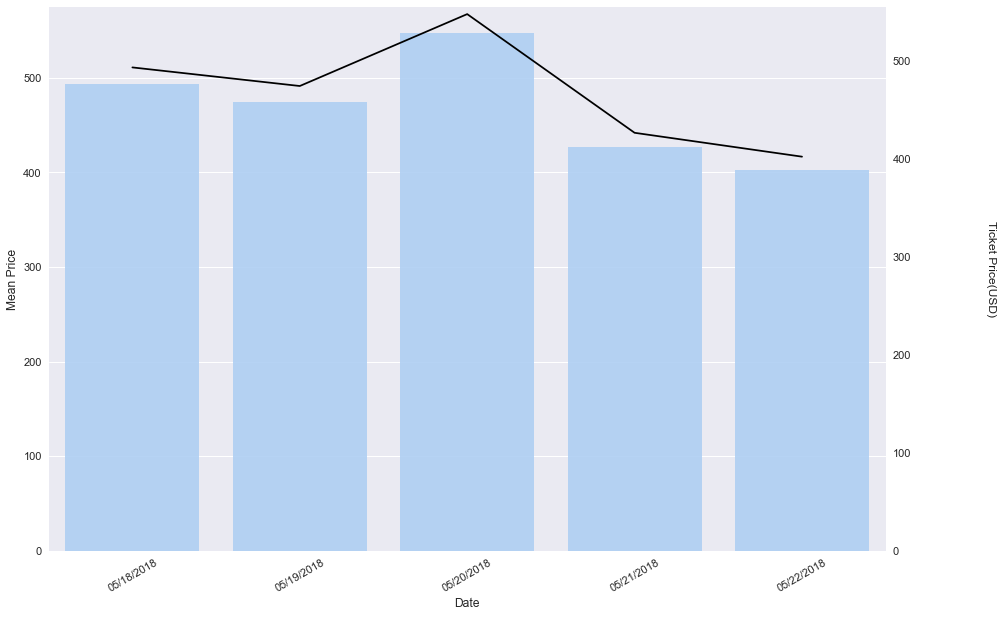

In [244]:
jfk_sin_price = price_analyse('IAD',"SFO",5)

## Objectives accomplished
* A net fuel efficiency parameter for trips was derived. 
* Made use of a majority of concepts taught in the course. 
* Comparison between fuel economy and ticket cost.
* Ability to analyze the operating patterns of various carriers.
* We can now perform a time series analysis of how price varies from a given date. 